# 1.0 Camera Demonstration 

Scaler and KNN model loaded successfully.


c:\Users\Ethan\Documents\Codes\CM2603-Data_Science_Project-G20\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\Ethan\Documents\Codes\CM2603-Data_Science_Project-G20\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\Ethan\Documents\Codes\CM2603-Data_Science_Project-G20\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\Ethan\Documents\Codes\CM2603-Data_Science_Project-G20\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\Ethan\Documents\Codes\CM2603-Data_Science_P


--- Fall Detection Summary ---
Total Falls Detected: 0
Falls Over 5 Seconds: 0
Fall Durations: []
Non-Fall Durations: []


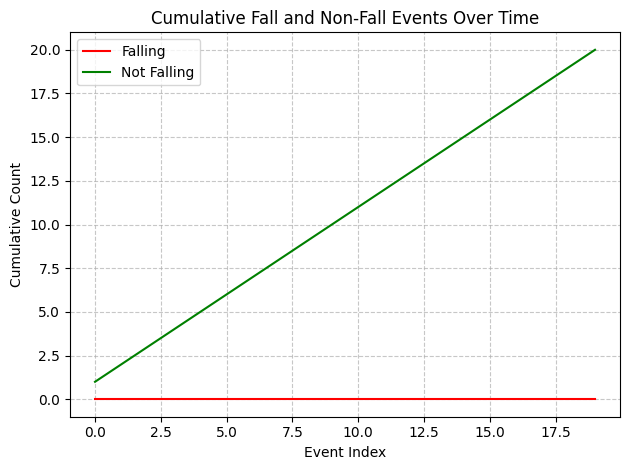

In [6]:
import cv2 as cv
import mediapipe as mp
import numpy as np
import csv
import time
import os
import pickle
import joblib
import threading
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from datetime import datetime
from collections import deque

# ------------------ Load the scaler and KNN model ------------------

base_dir = os.getcwd()
model_dir = os.path.join(base_dir, "models" , "cam")

scaler_path = os.path.join(model_dir, "scaler.pkl")
model_path = os.path.join(model_dir, "knn_model.pkl")

try:
    scaler = joblib.load(scaler_path)  
    with open(model_path, "rb") as model_file:
        knn_model = pickle.load(model_file)
    print("Scaler and KNN model loaded successfully.")
except FileNotFoundError as e:
    print(f"Error: {e}\nEnsure 'scaler.pkl' and 'knn_model.pkl' exist in the 'KNN_model' folder.")
    exit(1)

# ------------------ Initialize MediaPipe Pose ------------------

mp_pose = mp.solutions.pose
mp_drawing = mp.solutions.drawing_utils
non_face_indices = list(range(11, 33))

cap = cv.VideoCapture(0)

fall_count = 0
long_fall_count = 0
fall_start_time = None
non_fall_start_time = time.time()
fall_durations = []
non_fall_durations = []
data_log = []

fourcc = cv.VideoWriter_fourcc(*'mp4v')
fall_video_writer = None
recording = False
video_filename = None

recordings_dir = os.path.join(base_dir, "output" , "camera_model" ,"recordings")
os.makedirs(recordings_dir, exist_ok=True)


# ------------------ Function to Run Fall Detection ------------------

def fall_detection():
    global fall_count, long_fall_count, fall_start_time, recording, fall_video_writer, video_filename
    with mp_pose.Pose(min_detection_confidence=0.3, min_tracking_confidence=0.3) as pose:
        while cap.isOpened():
            ret, frame = cap.read()
            if not ret:
                print("Failed to capture frame.")
                break

            image = cv.resize(frame, (640, 480))
            image_rgb = cv.cvtColor(image, cv.COLOR_BGR2RGB)
            results = pose.process(image_rgb)

            current_time = time.time()

            if results.pose_landmarks:
                height, width, _ = image.shape
                landmarks = results.pose_landmarks.landmark
                filtered_landmarks = [landmarks[i] for i in non_face_indices]

                x_coords = [lm.x * width for lm in filtered_landmarks]
                y_coords = [lm.y * height for lm in filtered_landmarks]
                visibilities = [lm.visibility for lm in filtered_landmarks]

                x_min, x_max = min(x_coords), max(x_coords)
                y_min, y_max = min(y_coords), max(y_coords)
                box_width = x_max - x_min
                box_height = y_max - y_min

                features_input = np.array([np.mean(x_coords), np.mean(y_coords), np.mean(visibilities), box_width, box_height])
                features_input_scaled = scaler.transform([features_input])

                prediction = knn_model.predict(features_input_scaled)[0]
                label = "Falling" if prediction == 1 else "Not Falling"

                if prediction == 1:
                    if fall_start_time is None:
                        fall_start_time = current_time
                        non_fall_durations.append(current_time - non_fall_start_time)

                        timestamp_str = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
                        video_filename = os.path.join(recordings_dir, f"fall_{timestamp_str}.mp4")

                        fall_video_writer = cv.VideoWriter(video_filename, fourcc, 20.0, (640, 480))
                        recording = True

                    fall_count += 1

                    if recording and fall_video_writer:
                        fall_video_writer.write(frame)

                else:
                    if fall_start_time:
                        fall_duration = current_time - fall_start_time
                        fall_durations.append(fall_duration)

                        if fall_duration > 5:
                            long_fall_count += 1
                        else:
                            if recording and fall_video_writer:
                                fall_video_writer.release()
                                recording = False

                            time.sleep(0.1)
                            if video_filename and os.path.exists(video_filename):
                                try:
                                    os.remove(video_filename)
                                except PermissionError:
                                    print(f"Warning: Could not delete {video_filename}.")

                        if recording and fall_video_writer:
                            fall_video_writer.release()
                            recording = False

                        fall_start_time = None

                    non_fall_start_time = current_time

                data_log.append([round(current_time, 2), label])

                mp_drawing.draw_landmarks(
                    frame,
                    results.pose_landmarks,
                    mp_pose.POSE_CONNECTIONS,
                    mp_drawing.DrawingSpec(color=(245, 117, 66), thickness=2, circle_radius=2),
                    mp_drawing.DrawingSpec(color=(245, 66, 230), thickness=2, circle_radius=2),
                )
                cv.rectangle(frame, (int(x_min), int(y_min)), (int(x_max), int(y_max)), (0, 255, 0), 2)
                cv.putText(frame, label, (50, 50), cv.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)

            cv.imshow("Fall Detection", frame)
            if cv.waitKey(10) & 0xFF == ord('q'):
                break

    cap.release()
    cv.destroyAllWindows()

    log_path = os.path.join(base_dir, "output" , "camera_model" ,"fall_detection_log.csv")
    with open(log_path, "w", newline="") as file:
        writer = csv.writer(file)
        writer.writerow(["Timestamp", "Status"])
        writer.writerows(data_log)

    print(f"\n--- Fall Detection Summary ---")
    print(f"Total Falls Detected: {fall_count}")
    print(f"Falls Over 5 Seconds: {long_fall_count}")
    print(f"Fall Durations: {fall_durations}")
    print(f"Non-Fall Durations: {non_fall_durations}")


# ------------------ Plotting Falls ------------------

def plot_fall_summary_from_csv(csv_path):
    fall_cumulative = []
    non_fall_cumulative = []
    fall_count = 0
    non_fall_count = 0
    x = []

    try:
        with open(csv_path, mode='r') as file:
            reader = csv.DictReader(file)
            index = 0
            for row in reader:
                status = str(row["Status"])
                if status == "Falling":
                    fall_count += 1
                elif status == "Not Falling":
                    non_fall_count += 1
                
                x.append(index)
                fall_cumulative.append(fall_count)
                non_fall_cumulative.append(non_fall_count)
                index += 1

    except FileNotFoundError:
        print("CSV file not found.")
        return
    except KeyError:
        print("CSV file does not contain 'Status' column.")
        return

    plt.plot(x, fall_cumulative, 'r-', label='Falling')
    plt.plot(x, non_fall_cumulative, 'g-', label='Not Falling')

    plt.title("Cumulative Fall and Non-Fall Events Over Time")
    plt.xlabel("Event Index")
    plt.ylabel("Cumulative Count")
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()


fall_detection()

csv_path = os.path.join(base_dir, "output" , "camera_model" ,"fall_detection_log.csv") 
plot_fall_summary_from_csv(csv_path)



# 2.0 Accelorometer and Gyroscope model demonstration

# 3.0 Heart Rate & SP02 Model